# Assignment 6

                                "All the work herein is solely mine"
                                
                                
                                                                                                    
                                                          
                                                               Partner: Madhavan Kalkunte Ramachandra (madhkr)

# Problem 1

Implement expectation-maximization algorithm for Gaussian mixture models (see the EM algorithm below) in Python and call this program G<sup>k</sup> . As you present your code explain your protocol for
1. initializing each Gaussian
2. deciding ties
3. stopping criteria

# Solution

In [ ]:
pip install sklearn matplotlib pandas numpy

In [5]:
import random
import sys
import time

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

random.seed(5)

def read_ionosphere_text(dataset_name):
    dataframe = pd.read_csv(dataset_name, header=None)
    dataframe[len(dataframe.columns) - 1] = dataframe[len(dataframe.columns) - 1].apply(lambda x: 0 if x == 'b' else 1)
    return dataframe.values


def read_dataset(dataset_name):
    return np.genfromtxt(dataset_name)


def expectation_maximization(dataset_name, num_clusters):
    if dataset_name == 'ionosphere.data':
        data = read_ionosphere_text(dataset_name)
    else:
        data = read_dataset(dataset_name)
    cols = len(data[0])
    data_features = data[:, 0:cols - 1]
    data_classes = data[:, cols - 1:]
    num_features = len(data_features[0])

    # split the data set into training and testing sets. We will do the training on train set.
    x_train, y_train = data_features, data_classes

    cluster_means = []
    cluster_covariance = []
    priors = []
    n = len(x_train)

    start_time = time.perf_counter()

    for k in range(num_clusters):
        mean = []
        # random initialization of mean
        random_x = x_train[random.randint(0, n) - 1]
        for i in range(len(random_x)):
            mean.append(random_x[i])

        cluster_means.append(np.asarray(mean))

        # initialize covariance with identity matrix
        cluster_covariance.append(np.identity(num_features))

        # initial prior probability with uniform probability
        priors.append(1.0 / num_clusters)

    # initialize weights with zero
    w = np.zeros((num_clusters, n))
    iterations = 0

    # Repeat until convergence
    while True:
        # print("running iteration: ", iterations)
        iterations += 1
        # calculate the initial weights assigned to each feature. This loop calculates likelihood * prior
        for k in range(num_clusters):
            for j in range(n):
                w[k][j] = multivariate_normal.pdf(x_train[j], mean=cluster_means[k], cov=cluster_covariance[k],
                                                  allow_singular=True) * priors[k]
        # calculates the denominators i.e P(datapoint) for each datapoint and updates the weight
        calculated_sum = []
        for j in range(n):
            s = 0
            for k in range(num_clusters):
                s += w[k][j]
            calculated_sum.append(s)
            for k in range(num_clusters):
                w[k][j] = w[k][j] / s
        new_means = []
        new_covariance = []
        # for each cluster, recalculate the mean and covariance
        for k in range(num_clusters):
            new_mean = (1 / np.sum(w[k])) * np.matmul(w[k], x_train)
            new_covar = np.zeros((num_features, num_features))
            weight_sum = np.sum(w[k]).item()
            if weight_sum == 0:
                print(weight_sum)
            for j in range(n):
                feature_minus_mean = np.subtract(data_features[j], new_mean)[np.newaxis]
                a = w[k][j]
                sum_term = a * np.matmul(feature_minus_mean.T, feature_minus_mean)
                new_covar = np.add(new_covar, sum_term)
            new_covar = (1 / weight_sum) * new_covar
            new_covar[np.diag_indices_from(new_covar)] += 0.00001
            new_means.append(new_mean)
            new_covariance.append(new_covar)
            priors[k] = weight_sum / len(data_features)

        # check if the difference between new mean calculated and existing mean if small enough to consider convergence.
        diff = 0
        for k in range(num_clusters):
            diff += np.linalg.norm(np.subtract(cluster_means[k], new_means[k])) ** 2
        # check for convergence
        if diff <= 0.0001:
            break

        # update the mean and covariance
        cluster_means = new_means
        cluster_covariance = new_covariance

    # calculate the mean of two classes of training set.
    good_cluster, bad_cluster = [], []
    for j in range(n):
        if int(y_train[j].item()) == 0:
            bad_cluster.append(x_train[j])
        else:
            good_cluster.append(x_train[j])
    good_cluster_mean = np.mean(np.array(good_cluster), axis=0)
    bad_cluster_mean = np.mean(np.array(bad_cluster), axis=0)

    # decide which k is good cluster and which k is bad cluster in our clusters
    # cluster_mapping = {0: 0, 1: 1}
    cluster_mapping = {}

    def f(x):
        return x ** 2

    vectorized_square = np.vectorize(f)
    
    # calculuate the euclidian distance between actual mean and calculated cluster means to determine which 
    # of our clusters corressponds to which of the actual clusters.
    for k in range(num_clusters):
        g_minus_k = np.subtract(cluster_means[k], good_cluster_mean)
        g_minus_k = vectorized_square(g_minus_k)
        g = np.sqrt(np.sum(g_minus_k).item())
        b_minus_k = np.subtract(cluster_means[k], bad_cluster_mean)
        b_minus_k = vectorized_square(b_minus_k)
        b = np.sqrt(np.sum(b_minus_k).item())
        if g < b:
            cluster_mapping[k] = 1
        else:
            cluster_mapping[k] = 0
            
    # make hard assignments and calculate the error rate
    errors = 0
    for j in range(len(x_train)):
        prob = -sys.maxsize
        prob_sum = 0
        for k in range(num_clusters):
            prob_sum += w[k][j]
            if w[k][j] > prob:
                prob = w[k][j]
                assigned_cluster = cluster_mapping[k]
        actual_cluster = y_train[j].item()
        if int(assigned_cluster) != int(actual_cluster):
            errors += 1
    end_time = time.perf_counter()

    return {'error': errors / len(x_train), 'iterations': iterations, 'runtime': end_time - start_time}

print("Ionosphere dataset: ", expectation_maximization('ionosphere.data', 2))
print("Ringnorm dataset: ", expectation_maximization('Dataset.data', 2))


Ionosphere dataset:  {'error': 0.10541310541310542, 'iterations': 8, 'runtime': 1.5694753490388393}
Ringnorm dataset:  {'error': 0.014054054054054054, 'iterations': 8, 'runtime': 16.648421663965564}


## Approach:

### Expectation Maximization(EM):

Expectation Maximization algorithm is a very useful method to find the maximum likelihood when the model depends on latent variables. 

### 1. Initializing Each Guassian:

The step of <u>Initialising Gaussian</u> consists of **Mean Initialization**,**Covariance Initialization** and **Prior Initialization**.

For the n datapoints in the dataset we choose a random number r in the range of 0 to n (n exclusive). The datapoint at that index represented by r is initialised as mean of the cluster. This is called **Mean Initialization**. 
> ~~~
for k in range(num_clusters):
        mean = []
        # random initialization of mean
        random_x = x_train[random.randint(0, n) - 1]
        for i in range(len(random_x)):
            mean.append(random_x[i])
        cluster_means.append(np.asarray(mean))
    
In **Covariance Initilization** the default initialization of covariance matrix to identity matrix. 
>
~~~
        # initialize covariance with identity matrix
        cluster_covariance.append(np.identity(num_features))
~~~
In **Prior Initialization** the prior probability assigned is uniform i.e 1/k for k clusters. This is assigned for each cluster.

>
~~~
        # initial prior probability with uniform probability
        priors.append(1.0 / num_clusters)
~~~


### 2. Deciding Ties:

1. Tie may occur when all actual clusters are equidistant from the given cluster:

We assign calculated cluster to nearest actual clusters by calculating the euclidean distance between the actual cluster mean and calculated cluster mean.This problem can be overcome by assigning the calculated cluster to the cluster which occurs first in order.

2. Datapoints have same probability for each cluster:

For example when x datapoint has probability say 0.6 assigned for both cluster 1 and cluster 2, there occurs a tie on which cluster to assign. This can also be resolved by assigning the datapoint to the cluster which occurs first in order.So in the above example x datapoint is assigned to cluster 1.


### 3. Stopping Criteria:

The algorithm stops when the cluster means have converged. 

>For cluster i, let mean be $\mu_i$ then algorithm is converged when $\Sigma^k \mid \mid \mu_i^t - \mu_i ^ {t-1} \mid \mid ^ 2 < 0.0001. $

where $k$ is number of clusters and $t$ be the current iteration number. 

# Problem 3.2

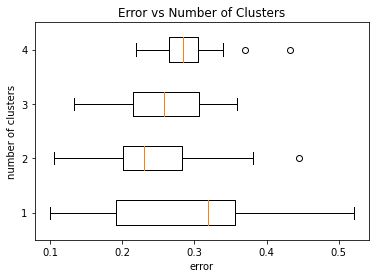

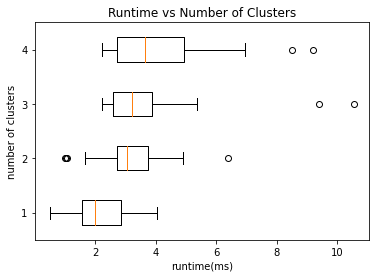

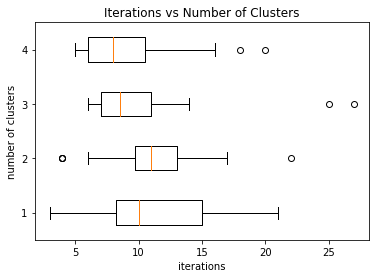

<Figure size 432x288 with 0 Axes>

In [3]:
def run_experiment_ionosphere():
    number_clusters = [2, 3, 4, 5]
    results = {}

    for k in number_clusters:
        runtimes = []
        iterations = []
        errors = []
        for run in range(20):
            cur_result = expectation_maximization('ionosphere.data', k)
            runtimes.append(cur_result['runtime'])
            iterations.append(cur_result['iterations'])
            errors.append(cur_result['error'])
        results[k] = {'runtime': runtimes, 'iterations': iterations, 'error': errors}

    # Plotting whisker plot for error rate for different cluster numbers
    plt.boxplot([ results[x]['error'] for x in number_clusters], vert=0)
    plt.xlabel('error')
    plt.ylabel('number of clusters')
    plt.title('Error vs Number of Clusters')
    plt.show()
    plt.clf()
        
    # Plotting whisker plot for runtime for different cluster numbers
    plt.boxplot([ results[x]['runtime'] for x in number_clusters], vert=0)
    plt.xlabel('runtime(ms)')
    plt.ylabel('number of clusters')
    plt.title('Runtime vs Number of Clusters')
    plt.show()
    plt.clf()
    
    # Plotting whisker plot for iterations for different cluster numbers
    plt.boxplot([ results[x]['iterations'] for x in number_clusters], vert=0)
    plt.xlabel('iterations')
    plt.ylabel('number of clusters')
    plt.title('Iterations vs Number of Clusters')
    plt.show()
    plt.clf()

run_experiment_ionosphere()

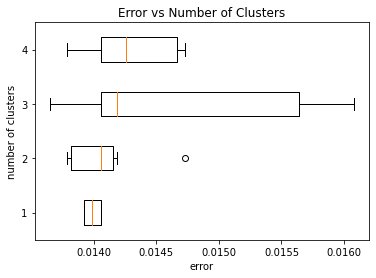

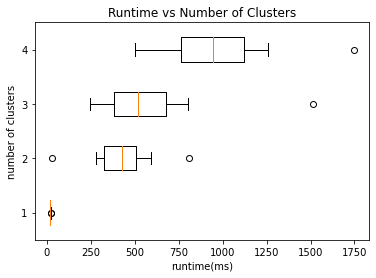

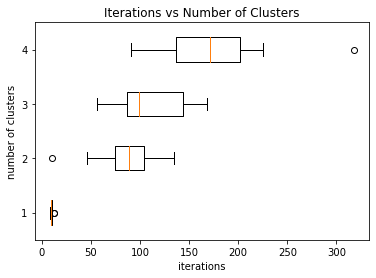

<Figure size 432x288 with 0 Axes>

In [4]:
def run_experiment_ringnorm():
    number_clusters = [2, 3, 4, 5]
    results = {}

    for k in number_clusters:
        runtimes = []
        iterations = []
        errors = []
        for run in range(20):
            cur_result = expectation_maximization('Dataset.data', k)
            runtimes.append(cur_result['runtime'])
            iterations.append(cur_result['iterations'])
            errors.append(cur_result['error'])
        results[k] = {'runtime': runtimes, 'iterations': iterations, 'error': errors}

    # Plotting whisker plot for error rate for different cluster numbers
    plt.boxplot([ results[x]['error'] for x in number_clusters], vert=0)
    plt.xlabel('error')
    plt.ylabel('number of clusters')
    plt.title('Error vs Number of Clusters')
    plt.show()
    plt.clf()
        
    # Plotting whisker plot for runtime for different cluster numbers
    plt.boxplot([ results[x]['runtime'] for x in number_clusters], vert=0)
    plt.xlabel('runtime(ms)')
    plt.ylabel('Number of Clusters')
    plt.title('Runtime vs Number of Clusters')
    plt.show()
    plt.clf()
    
    # Plotting whisker plot for iterations for different cluster numbers
    plt.boxplot([ results[x]['iterations'] for x in number_clusters], vert=0)
    plt.xlabel('iterations')
    plt.ylabel('number of clusters')
    plt.title('Iterations vs Number of Clusters')
    plt.show()
    plt.clf()
    
run_experiment_ringnorm()

### Graph Analysis:

> **NOTE: The number of clusters are zero index based so kindly consider the values of y-axis to be from 2,3,4..**

**Average error rates:** *Graph of Number of clusters vs Error rate*

1) Ringnorm dataset: We can observe error rate of approximately ~1.4%.

2) Ionosphere: We can observe error rate of approximately ~23%.

**Average iterations (for k=2):** *Graph of Number of clusters vs Average Iterations*

1) Ringnorm: When clusters considered is 2 we can observe the number of average iterations to be approximately ~10. From the graph we can deduct the values for other number of clusters by looking at the yellow line which us mean value in the box plots.

2) Ionosphere:When clusters considered is 2 we can observe the number of average iterations to be approximately ~8.

**Average run time (for k=2):** *Graph of Number of clusters vs Average Runtime*

1) Ringnorm: When clusters considered is 2 we can observe the average runtime to be approximately ~19 ms.

2) Ionosphere: When clusters considered is 2 we can observe the average runtime to be approximately ~2 ms.

### Trends:

1) Error rate for both datasets does not change much with increase in number of virtual clusters. This is because we map the virtual clusters to physical cluster before making hard assignments to data points.

2) Increase in number of clusters result in increase in iterations to converge and runtime as well. This is because there will be more terms (mean differences) that contribute to the difference and hence it will take more time to converge.

# Problem 3.1

Given a text D and a pattern P, describe an Ω(d+p) time method for finding the longest prefix of P that is a substring of D. The lengths of D and P are d and p, respectively.

## Solution:

Using the Trie data structure we can solve the longest prefix of pattern P in a text D in Ω(d+p).

### Algorithm:

* *Input: Text D, Pattern P*
* *Output: Longest Prefix String*

**LongestPrefix(D, P):**
```
1.  construct a TRIE for given text D
2.  let node = root of TRIE representation of text D
3.  longest_prefix = ''
4.  for each character ch in P :
5.      longest_prefix = node.value
6.      if node.reference[ch] != NULL:
7.         node = node.reference[ch]
8.      else:
9.         break - no further match for pattern exists in text
10. return longest_prefix
```

## Run time analysis

A Trie can be implemented in Ω(n * m) where n is the number of words in the text and m is the average length of a word in D. In other words n * m = d (total length of text / total number of characters in D). 
> **Hence creation of Trie can be done in Ω(d)**

**Further the for loop in lines 4 through 9 runs in linear time of length of Pattern p. i.e Ω(p)**

> **Hence the overall complexity of the algorithm = Ω(d) + Ω(p) = Ω(d+p)**



# Problem 3.2

X, Y, and Z are three arrays and each has m elements. For an arbitrary integer t, describe O(m<sup>2</sup> logm)-time algorithm to determine if there exist numbers, x in X, y in Y, and z in Z, such that t = x+y+z.


## Solution:


### Algorithm:

**ArbitarySum(X, Y, Z, t):**
```
1. Sort(Z)
2. for x in X:
3.   for y in Y:
4.      z_wanted = t - x - y
5.      if BinarySearch(Z, z_wanted) == True:
6.         return x, y, z_wanted
7. return -1 (not exists)
```
To get a O(m<sup>2</sup>logm) time complexity, we need to do the following:
* Lets assume each array X,Y,Z is of length m
* We can iterate over any of the two arrays (For ex:X and Y) out of three(X,Y,Z) given above. We can find the z value by subtracting x value from X and y value from Y from t(total value). Since there would be 2 for loops this operation runs in O(m<sup>2</sup>) time.
* We search the z value in Z array using **Binary Search** which runs in logarithmic time. The array must be sorted to apply Binary search so we sort Z.

### Runtime analysis:


1. Sorting of Z takes O(mlogm) time
2. Nested for loops in line 2 and 3 takes O(m<sup>2</sup>) time.
3. Body of nested for loop: Binary search takes O(logm) time
4. Therefore lines 2 through 6 takes m<sup>2</sup>logm time


> **Hence overall worst case time complexity is O(mlogm + m<sup>2</sup>logm) = O(m<sup>2</sup>logm)** 

# Problem 3.3

Describe an efficient algorithm for deleting a string from a compressed trie and analyze its running time.

## Solution:

### Approach:

To delete a string from compressed trie we do the following:
We consider a **NODE** datastructure to represent a trie node. We take the input of the algorithm to be a node, key to delete and depth of key found. We first check if the node is null, if yes we return null.

If the node is not null,we check if the key is complete word in trie i.e if it is a leaf node.If it is a leaf node we delete that node from the trie.

If the node is not a leaf node, then the node representing the word is a prefix to other words: mark the node with isWord to False, indicating  that the word no longer exists in the trie.

We check if the node is Empty using ***isEmpty()*** function which tells whether a node has children or not.

We denote compressed trie using Node data structure which consists of 

1. **value**:represents the value of the node.
2. **child**:references to children nodes
3. **isWord**: boolean flag which denotes whether a node represents the given word
```
class Node:
        value : String
        children : Node[]
        isWord : boolean
```    
### Algorithm: Deleting a key in Compressed trie

**DeleteKey(node, key, depth)**
```
if node == null:
    return null
    
label = node.value
start_index = depth
end_index = depth + label.length

// label is longer than remaining part of key to be matched. Hence there is no match for key.
if end_index > key.length
    return node 

// if part of key does not match with label, then key does not exist in TRIE, just return node
if key[start_index:end_index] != label
    return node

// check if key is completely matched.
if end_index == key.length and node.isWord
    // we have found the word, mark the node as not a word.
    node.isWord = False

    // remove the node if it is empty
    if node is empty
        node = null

    return node

// if we have not completely matched, we continue traversal from end_index recursively

node[end_index] = DeleteKey(node[end_index], key, end_index)

// remove the node if it is empty and does not represent a word
if node is empty and node.isWord = False
    node = null
    
return node

```

_A node is empty if all the children nodes are null._

**isEmpty(node)**
```
for each child in node.children:
    if node.children != null
        return False
return True
```
### Runtime Analysis:

The worst case time complexity for deletion of a key/ word from a compressed trie is **O(n) where n is the length of the key/ word to be deleted.**

It is O(n) because in the worst case the path to a word in a compressed trie will be equal to number of characters in the word.This will happen when every character of the word has atleast 2 children.


### References:

1. http://theoryofprogramming.com/2016/11/15/compressed-trie-tree/
2. https://www.geeksforgeeks.org/trie-insert-and-search/
3. https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137